Modified and translated code from [this source](https://www.kaggle.com/code/s4dead/crimes-in-boston-visualization/notebook).  Added the ability to get summary statistics for a path.

## Imports

In [5]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier


import alphashape

%matplotlib inline
sns.set()

from config import apiKeys
#from openrouteservice import client, places

import googlemaps
import polyline
from shapely.geometry import Polygon, LineString, Point
import geopandas



## Config variables

In [2]:
MAXYEAR = 2022
MINYEAR = 2000

## Data Import

In [11]:
dateparse = lambda x: pd.to_datetime(x, format='%m/%d/%Y %H:%M:%S',errors='coerce')

data = pd.read_csv('data/chicago/Crimes_-_2001_to_Present.csv', encoding='latin-1',
                   parse_dates=['Date'], date_parser=dateparse,dtype={'Description	': 'str'})

## Summary Statistics

In [14]:
data.isna().sum()

ID                            0
Case Number                   4
Date                    7591376
Block                         0
IUCR                          0
Primary Type                  0
Description                   0
Location Description       9453
Arrest                        0
Domestic                      0
Beat                          0
District                     47
Ward                     614844
Community Area           613478
FBI Code                      0
X Coordinate              80384
Y Coordinate              80384
Year                          0
Updated On                    0
Latitude                  80384
Longitude                 80384
Location                  80384
dtype: int64

### The unique values ​​themselves


In [15]:
for column in ['District', 'Year', 'Community Area','Ward']:
    print(f'{column}: {data[column].unique()}')

District: [ 9. 15.  6. 14. 10. 12.  8. 16.  5.  2.  4. 22.  3.  1.  7. 11. 17. 20.
 25. 18. 19. 24. 31. nan 21.]
Year: [2015 2018 2016 2014 2001 2020 2019 2012 2017 2013 2011 2007 2003 2010
 2008 2009 2002 2005 2006 2004 2021 2022]
Community Area: [61. 25. 44. 21. 71. 24. 31. 27. 63. 65. 11. 49. 39. 51. 15. 52. 12. 43.
 46. 32. 68. 14. 29.  2. 69. 23. 35.  8.  3.  6. 56. 28. 53. 50. 33. 13.
 74. 19. 45. 72. 22. 64.  7.  5. 26. 66. 59. 77.  1. 10. 67. 38. 41. 60.
 30. 54. 58. 48. 73. 70. 40. 34. 16. 18.  4. 17. 42. 37. 75. 62. 20. 57.
 76. 47. nan  9. 36. 55.  0.]
Ward: [12. 29.  8. 35. 28. 21. 32. 25. 27. 15. 13. 45. 34.  4.  1. 10. 38.  5.
  7.  2. 20. 39. 24. 40.  6. 37. 16.  3. 42. 46. 23.  9. 19. 50. 44. 47.
 11. 48. 49. 26. 33. 22. 30. 18. 43. 31. 36. 17. 14. 41. nan]


## Data cleansing/transformation


Remove unnecessary columns

In [16]:

data.drop(['Location', 'Updated On', 'Y Coordinate','X Coordinate','FBI Code'], axis=1, inplace=True)

We bring all unknown values ​​to a single form

In [17]:
data.Latitude.replace(-1, None, inplace=True)
data.Longitude.replace(-1, None, inplace=True)

## Map Visualization

### Finding county boundaries

Delete knowingly incomplete/inaccurate data

In [18]:
data_counties = data[['District', 'Latitude', 'Longitude']].dropna()
data_counties['Latitude'] = pd.to_numeric(data_counties['Latitude'])
data_counties['Longitude'] = pd.to_numeric(data_counties['Longitude'])

Getting rid of outliers using the nearest neighbor method

In [20]:
neigh = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
neigh.fit(data_counties[['Latitude', 'Longitude']], data_counties['District'])

KNeighborsClassifier(n_jobs=-1, n_neighbors=100)

Assigning new county numbers

In [22]:
data_counties['District'] = neigh.predict(data_counties[['Latitude', 'Longitude']])

Get bounds for new labels

In [23]:
district_groups = data_counties.groupby(['District'])
geojson = {'type': 'FeatureCollection'}
geojson['features'] = []
# Multipolygons are being generated will keep maximal shape as district boundary
counter = 0
for district, data_district in dict(list(district_groups)).items():
    pointOutline = alphashape.alphashape(data_district[['Longitude', 'Latitude']].values,
                                           alpha=np.sqrt(data_district.shape[0]) * 1.5)
    hullGeom = {}
    if pointOutline.geom_type == 'MultiPolygon':
        maxSize = 0
        for geom in pointOutline.geoms:
            x,y = geom.exterior.xy
            geomSize = len(x)
            if geomSize > maxSize:
                maxSize = geomSize
                hullGeom = geom.exterior.coords
    else:
        hullGeom = pointOutline.exterior.coords

    hull_curr = list(hullGeom)
    geojson['features'].append({'type': 'Feature',
                                'geometry': {
                                    'type': 'Polygon',
                                    'coordinates': [hull_curr]
                                },
                                'properties': {'district': district}})
    counter = counter + 1

/home/jvarela/anaconda3/envs/mapVisualization/lib/python3.7/site-packages/alphashape/alphashape.py:50: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4 or (alpha is not None and alpha <= 0):
/home/jvarela/anaconda3/envs/mapVisualization/lib/python3.7/site-packages/alphashape/alphashape.py:68: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  coords = np.array([point.coords[0] for point in points])
/home/jvarela/anaconda3/envs/mapVisualization/lib/python3.7/site-packages/alphashape/alphashape.py:105: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  result = cascaded_union(triangles)


Let's look at the resulting boundaries

In [ ]:
fig = px.choropleth_mapbox(data_counties, geojson=geojson, color='District',
                           locations='District', featureidkey='properties.district',
                           center={'lat': 41.8781, 'lon': -87.623177},
                           mapbox_style='carto-positron', zoom=10.5,
                           opacity=0.5)
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()

#### Distribution of crimes by groups for different partitions

In [28]:
# Drawing histograms
def bar_chart(x_vals, y_vals, title=None, x_label=None, y_label=None, if_plot_vals=False):
    n = len(x_vals)
    x_pos = np.arange(n)

    plt.figure(figsize=(12, 8))
    plt.bar(x_pos, y_vals, align='center', alpha=0.6)
    plt.xticks(x_pos, x_vals)
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)

    if if_plot_vals:
        for pos, val in zip(x_pos, y_vals):
            plt.text(pos, val, val, ha='center')

    plt.show()

Distribution of the number of all crimes by years (ignore 2022 as the year is not done)

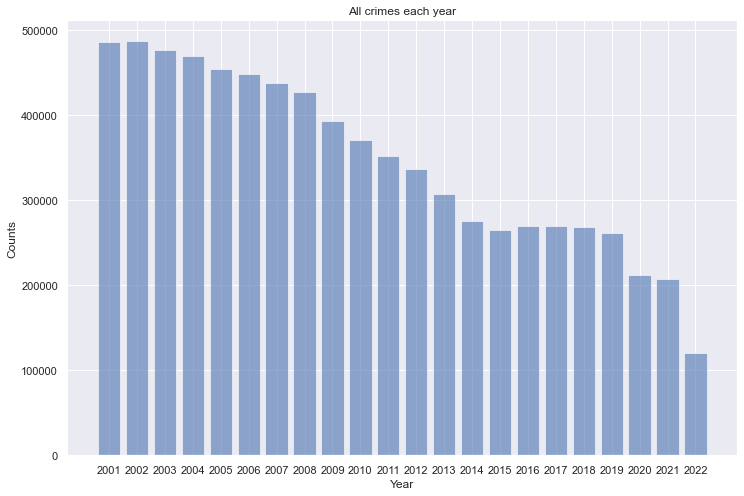

In [29]:
data_year = data.groupby(['Year']).size().reset_index(name='Counts')

bar_chart(data_year.Year, data_year.Counts, 'All crimes each year', 'Year', 'Counts')

## We now look at summary stats for specific years

In [30]:
def getDataForSpecificYear(dataFrame,year):
    assert year >= MINYEAR and year <= MAXYEAR,"invalid year value"
    return dataFrame[dataFrame['Year'] == year]

By county


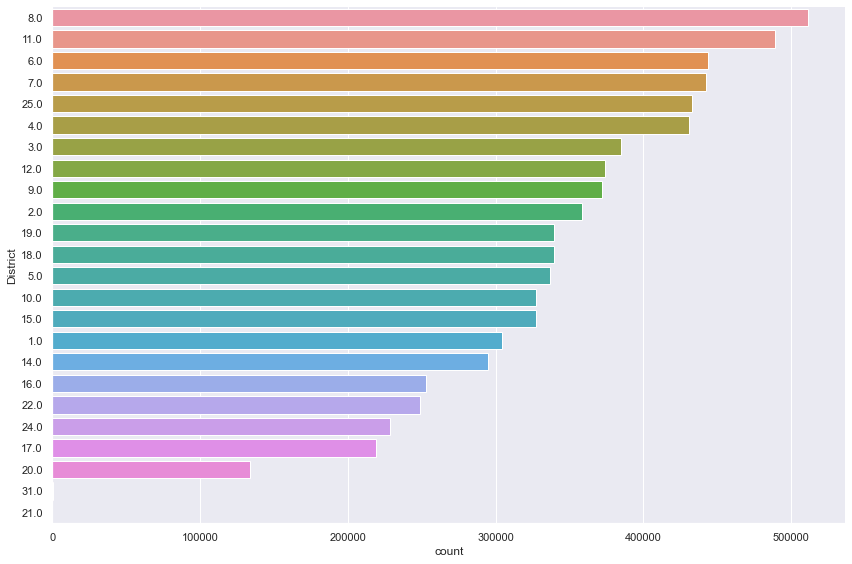

In [32]:
sns.catplot(y='District',
            kind='count',
            height=8,
            aspect=1.5,
            order=data.District.value_counts().index,
            data=data)

## Map Visualizations

View crime count by district

In [ ]:
data_county = data.groupby(['District']).size().reset_index(name='Counts')

fig = px.choropleth_mapbox(data_county, geojson=geojson, color='Counts',
                           locations='District', featureidkey='properties.district',
                           color_continuous_scale="Viridis", range_color=(0, data_county['Counts'].max()),
                           center={'lat': 41.8781, 'lon': -87.623177},
                           mapbox_style="carto-positron", zoom=10.5,
                           opacity=0.5, labels={'Area': 'Crimes number'})
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()

## Violent Crimes

Now we focus on violent crimes such as homicide, assault, battery.  We take as our key words from the wikipedia description:

[Depending on the jurisdiction, violent crimes may include: homicide, murder, assault, manslaughter, sexual assault, rape, robbery, negligence, endangerment, kidnapping (abduction), extortion, and harassment.](https://en.wikipedia.org/wiki/Violent_crime#Violent_crime_by_country)

However we will ignore 'negligence', and 'endangerment'.

In [36]:

def joinDataFrames(dataFrameArray):
    areEqual = all([len(dataFrameArray[0].columns.intersection(df.columns)) 
      == dataFrameArray[0].shape[1] for df in dataFrameArray])
    assert areEqual, "can not join data frames with different columns"
    result = pd.concat(dataFrameArray)
    result = result.drop_duplicates()
    return result

def selectDataFramesByKeyWord(dataFrame ,keyWord, columsToQuery=['Description','Location Description','Primary Type'],lowerStrings=True):
    # df = df[df['Credit-Rating'].str.contains('Fair')]
    dataFrameArray = []
    if lowerStrings:
        for columnName in columsToQuery:
            dataWithValues = dataFrame[dataFrame[columnName].notna()]
            dataWithValues[columnName] = dataWithValues[columnName].apply(str.lower)
            queryWord = keyWord.lower()
            filteredDF = dataWithValues[dataWithValues[columnName].str.contains(queryWord)]
            dataFrameArray.append(filteredDF)
    else:
        for columnName in columsToQuery:
            dataWithValues = dataFrame[dataFrame[columnName].notna()]
            dataWithValues[columnName] = dataWithValues[columnName].apply(str.lower)
            queryWord = keyWord
            filteredDF = dataWithValues[dataWithValues[columnName].str.contains(queryWord)]
            dataFrameArray.append(filteredDF)
    return joinDataFrames(dataFrameArray)

In [37]:
violentCrimeKeyWords = ['Aggravated assault','Homicide', 'HOME INVASION', 
'Manslaughter', 'HUMAN TRAFFICKING', 'BODILY HARM', 'MURDER ', 'BATTERY', 
'Kidnapping', 'ROBBERY ATTEMPT - OTHER WEAPON', 'ROBBERY - STREET', 'ROBBERY - HOME INVASION', 
'ROBBERY - CAR JACKING', 'ROBBERY - KNIFE']


dataWithLocations = data[data['Latitude'].notna() & data['Longitude'].notna()]
violentCrimesDFs = [selectDataFramesByKeyWord(dataWithLocations,keyWordVal) for keyWordVal in violentCrimeKeyWords]
violentCrimeDF = joinDataFrames(violentCrimesDFs)
len(violentCrimeDF.index)

/home/jvarela/anaconda3/envs/mapVisualization/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(645628, 70)

In [45]:
homicideKeyWords = ['Homicide','Manslaughter','degree murder']


homicideCrimesDFs =[selectDataFramesByKeyWord(dataWithLocations,keyWordVal) for keyWordVal in homicideKeyWords]
homicideCrimeDF = joinDataFrames(homicideCrimesDFs)
len(homicideCrimeDF.index)

/home/jvarela/anaconda3/envs/mapVisualization/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



12029

In [ ]:
violent_data_county = violentCrimeDF.groupby(['District']).size().reset_index(name='Counts')

fig = px.choropleth_mapbox(violent_data_county, geojson=geojson, color='Counts',
                           locations='District', featureidkey='properties.district',
                           color_continuous_scale="Viridis", range_color=(0, violent_data_county['Counts'].max()),
                           center={'lat': 41.8781, 'lon': -87.623177},
                           mapbox_style="carto-positron", zoom=10.5,
                           opacity=0.5, labels={'Area': 'Crimes number'})
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()

homicide counts by district

In [ ]:
homicide_data_county = homicideCrimeDF.groupby(['District']).size().reset_index(name='Counts')

fig = px.choropleth_mapbox(homicide_data_county, geojson=geojson, color='Counts',
                           locations='District', featureidkey='properties.district',
                           color_continuous_scale="Viridis", range_color=(0, homicide_data_county['Counts'].max()),
                           center={'lat': 41.8781, 'lon': -87.623177},
                           mapbox_style="carto-positron", zoom=10.5,
                           opacity=0.5, labels={'Area': 'Crimes number'})
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()
